In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
image_size = 150
batch_size = 32
epochs = 50

In [5]:
data_folder = 'data\data1\Pepper'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    f"{data_folder}",
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=batch_size,
)

Found 2475 files belonging to 2 classes.


In [6]:
class_names = dataset.class_names
num_classes = len(class_names)
class_names

['Pepper_bell_Bacterial_spot', 'Pepper_bell_healthy']

In [7]:
class_dis = [len(os.listdir(f'{data_folder}\{name}')) for name in class_names]
class_dis

[997, 1478]

In [8]:
import plotly.express as px
fig = px.pie(names=class_names, values=class_dis, hole=0.3)
fig.update_layout({"title":{"text":"Distibution of classes", "x":0.50}})
fig.show()

(32, 150, 150, 3)
[0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1]


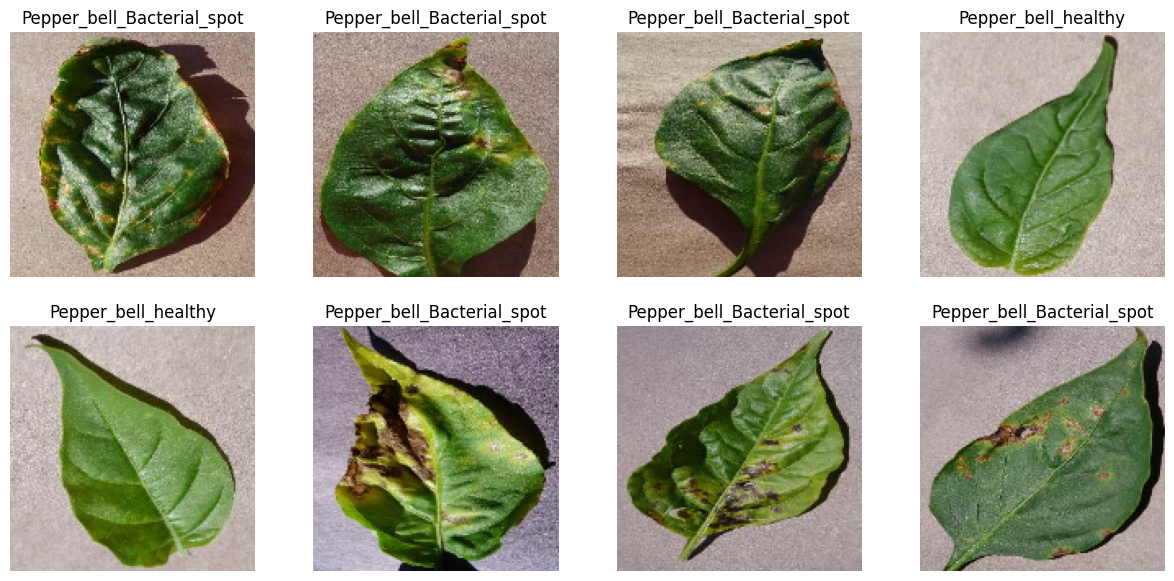

In [9]:
plt.figure(figsize=(15,7))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(8):
        ax = plt.subplot(2,4,i+1)
        plt.imshow(image_batch[i].numpy().astype(int)) 
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

In [7]:
from modules import utils

train, val, test = utils.dataset_partition(dataset)

In [8]:
print(len(train), len(val), len(test))
print(train)

62 7 9
<TakeDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

In [10]:
from tensorflow.keras import layers, models

In [11]:
# Data preprocessing
data_preprocess = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255),

])

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from modules.History import PlotLossMetric
from modules.CallBacks import CheckPointLoss

In [13]:
from tensorflow.keras import optimizers 
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

# Set up compile
opt_adam = optimizers.Adam(learning_rate=0.0001, decay=1e-6)
metric = 'accuracy'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

#Callback
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)
earlystop_callback = EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = CheckPointLoss('pepper')

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

input_shape = (batch_size, image_size, image_size, 3)

# Build CNN model

model = models.Sequential([
    data_preprocess,
    data_augmentation,
    
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),


    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax'),

])

model.build(input_shape=input_shape)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 150, 150, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 150, 150, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 148, 148, 32)        896       
                                                                 
 batch_normalization (BatchN  (32, 148, 148, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (32, 74, 74, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 72, 72, 64)         

In [15]:
model.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [29]:
hist = model.fit(
    train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 0.6771 - accuracy: 0.8548
Epoch 1: val_loss did not improve from 0.15767
62/62 [==============================] - 5s 64ms/step - loss: 0.6771 - accuracy: 0.8548 - val_loss: 0.9840 - val_accuracy: 0.5938
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.9249
Epoch 2: val_loss did not improve from 0.15767
62/62 [==============================] - 4s 60ms/step - loss: 0.2165 - accuracy: 0.9249 - val_loss: 0.5506 - val_accuracy: 0.7098
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9481
Epoch 3: val_loss did not improve from 0.15767
62/62 [==============================] - 4s 62ms/step - loss: 0.1423 - accuracy: 0.9481 - val_loss: 2.2985 - val_accuracy: 0.4911
Epoch 4/50
62/62 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.9602
Epoch 4: val_loss did not improve from 0.15767
62/62 [==============================] - 4s 58

In [16]:
model_ver = max([int(i) for i in os.listdir("checkpoints/pepper")]+[0])
latest = tf.train.latest_checkpoint(f"checkpoints/pepper/{model_ver}")
print(latest)
model.load_weights(latest)
scores = model.evaluate(test)
scores

checkpoints/pepper/1\43.ckpt
9/9 [==============================] - 12s 323ms/step - loss: 0.0151 - accuracy: 0.9888


[0.015122226439416409, 0.9887640476226807]

In [43]:
utils.save_model(model, folder_name='pepper')

INFO:tensorflow:Assets written to: models/pepper/2\assets



    Actual label: Pepper_bell_healthy
    Predict label: Pepper_bell_healthy
    


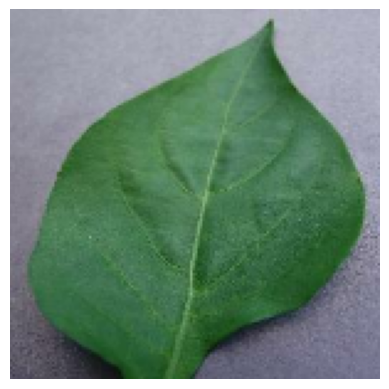

In [44]:
for image_batch, label_batch in test.take(1):
    first_image = image_batch[0].numpy().astype(int)
    first_label = class_names[label_batch[0].numpy()]
    prediction_batch = model.predict(image_batch)
    predict_label = class_names[np.argmax(prediction_batch[0])]
    print(f'''
    Actual label: {first_label}
    Predict label: {predict_label}
    ''')
    plt.imshow(first_image)
    plt.axis('off')

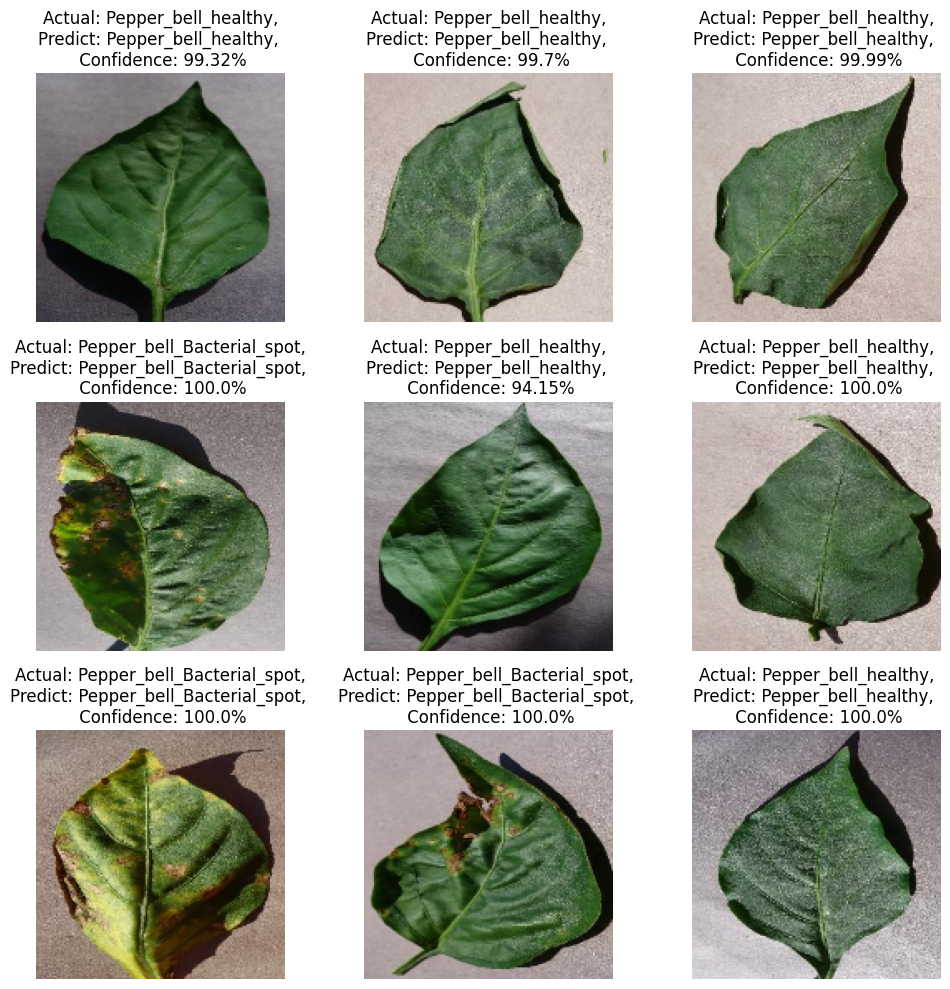

In [21]:
is_break = False
while not is_break:
    for images, labels in test.take(1):
        num_img = 9
        if len(images)>=num_img:
            is_break = True
            fig = plt.figure(figsize=(10,10))
            for i in range(num_img):
                ax = plt.subplot(3,3,i+1)
                predict_label, confidence = utils.predict(model, images[i], class_names)
                actual_label = class_names[labels[i]]
                plt.imshow(images[i].numpy().astype(int))
                plt.title(f'Actual: {actual_label},\nPredict: {predict_label}, \n Confidence: {confidence}%', fontsize=12)
                plt.axis('off')

            fig.tight_layout()

In [17]:
from modules import utils
precision_scores, recall_scores, f1_score, confusion_matrix_values = utils.precision_recall(model, test)

Average Precision:
0.9893302968960865
Average Recall:
0.9899859943977591
F1 Score:
0.9896580370389111
Confusion Matrix:
[[114   2]
 [  1 150]]


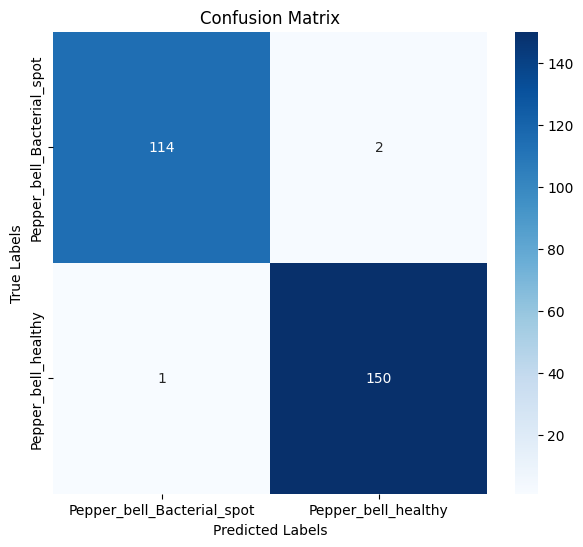

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix as a heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_matrix_values, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()